In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import PIL
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense,MaxPool2D,Conv2D,Conv2DTranspose,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Lambda,LeakyReLU,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow import Tensor
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random

from importlib import reload 
from monk import Dataset
   
from PIL import Image 
import PIL 
  


In [3]:
import ncut_loss

import build_Unet

import build_Wnet

import getData

from datasets import get_damaged_generator

from datasets import get_non_damaged_generator

from datasets import get_mixed_generator

import seaborn as sns

import pandas as pd

from getData import get_generator


In [4]:
#TRAIN_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_0.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_1.json"]

TEST_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_3.json"]



damaged_generator = get_generator(TEST_DATASET,10,256,damaged=True)

non_damaged_generator = get_generator(TEST_DATASET,10,256,damaged=False)



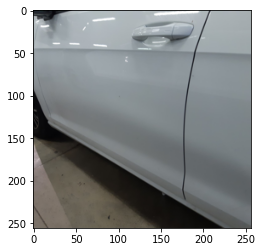

In [5]:
damaged_samples = damaged_generator.__getitem__(5)
plt.imshow((damaged_samples[0]+1)/2)


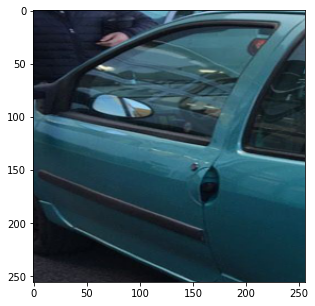

In [6]:
no_damaged_samples = non_damaged_generator.__getitem__(np.random.randint(1,1000))
plt.figure(figsize=(5,5))
plt.imshow((no_damaged_samples[0]+1)/2)

In [7]:
#encoder = build_Unet.build_Unet(K=4,stages = [1,2,3,4],filters = 64,type='encoder',input_size=128,use_dropout=False)
#decoder = build_Unet.build_Unet(K=4,stages = [1,2,3,4],filters = 64,type='decoder',input_size=128,use_dropout=False)
#wn = build_Wnet.Wnet(encoder,decoder,(128,128))

K=18
INPUT_DIM=128
USE_DROPOUT=False

encoder = build_Unet.Unet(K=K,type='encoder',input_size=INPUT_DIM,do_dropout=USE_DROPOUT)
decoder = build_Unet.Unet(K=K,type='decoder',input_size=INPUT_DIM,do_dropout=USE_DROPOUT)
wn = build_Wnet.Wnet(encoder,decoder,(INPUT_DIM,INPUT_DIM))


def custom_loss(y_true, y_pred):
    return K.mean(y_true - y_pred)**2

# Compile the model
wn.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.003),
    loss_fn_segmentation = ncut_loss.compute_soft_ncuts,
    loss_fn_reconstruction = tf.keras.losses.MeanSquaredError()
)

neighbor_filter=ncut_loss.neighbor_filter((128,128))


In [8]:
wn.load_weights("/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/WnetDropoutIdea/ckpt2000")

In [9]:
import tensorflow_addons as tfa

def rescale(image):
    return( (((image+1)/2)*255 ).astype("uint8") )


def visualise_seg(image,encoder):
    
    #input_noisy = tfa.image.gaussian_filter2d(image,(10,10),5) + np.random.normal(0, 0.1, image.shape)
    
    sigma=3
    blur_kernel=10
    noise_amp=0.1
    
    image_blurred = tfa.image.gaussian_filter2d( image,(blur_kernel,blur_kernel),sigma)
    noise = np.random.normal(0, noise_amp, image.shape)
    image_blurred = image_blurred + noise
    input_noisy = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)
    
    
    input_noisy = tf.expand_dims(input_noisy, 0)
    input_noisy = tf.expand_dims(image, 0)
    print(image.shape)
    
    seg = encoder(input_noisy)
    ag = tf.math.argmax(seg, axis=-1, output_type=tf.dtypes.int64)
        
    
    
    
    res_blur = wn(input_noisy).numpy()[0]
    res_blur = rescale(res_blur)
    
   
    
    plt.figure(figsize=(15,15))

    plt.subplot(1,4,1)
    plt.imshow(rescale(np.array(input_noisy)[0]))
    plt.subplot(1,4,2)
    plt.imshow(ag[0])
    plt.subplot(1,4,3)
    plt.imshow((res_blur))
    plt.subplot(1,4,4)
    plt.imshow(rescale(np.array(image)))
   
    
    
    return(ag,seg)

(256, 256, 3)


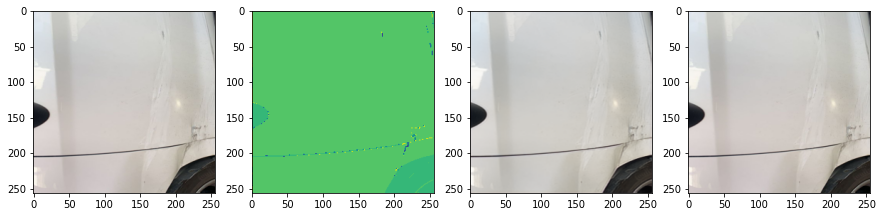

In [10]:
ag,seg = visualise_seg(damaged_samples[6],wn.encoder)


In [12]:
seg1 =wn.encoder(tf.expand_dims(no_damaged_samples[3],0))
avg1 = tf.keras.layers.GlobalAveragePooling2D()(seg1)
seg2 =wn.encoder(tf.expand_dims(no_damaged_samples[4],0))
avg2 = tf.keras.layers.GlobalAveragePooling2D()(seg2)
x = np.array([avg1[0],avg2[0]])

print(x.shape)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(x)
print(kmeans.labels_)

(2, 18)
[0 1]


In [13]:
X=[]

for k in range(0,10):
    print(k)
    no_dams = tf.convert_to_tensor(non_damaged_generator.__getitem__(k))   
    dams = tf.convert_to_tensor(damaged_generator.__getitem__(k))
    plt.figure(figsize=(15,15))
    for i in range(0,10):
    
        no_dam=no_dams[i]
        dam=dams[i]

        seg1 = wn.encoder(tf.expand_dims(no_dam,0))
        avg1 = tf.keras.layers.GlobalAveragePooling2D()(seg1)
        seg2 =wn.encoder(tf.expand_dims(dam,0))
        avg2 = tf.keras.layers.GlobalAveragePooling2D()(seg2)

        X.append(avg1[0])
        X.append(avg2[0])

    
X= np.array(X)
    

0
1


KeyboardInterrupt: 

<Figure size 1080x1080 with 0 Axes>

In [71]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print(kmeans.labels_)

[0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1
 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1
 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0]


In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],c=[0,1]*100)

PCA(n_components=2)

[0.65846294 0.16589159]


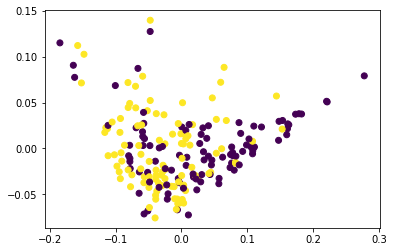

In [30]:
X_pca[:,0].shape

(20,)

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]